# Analysis of dataset

In [71]:
import numpy as np #Means that we will import all the functions from the numpy package
import pylab as plt
import pandas as pd
from collections import OrderedDict
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import KFold, cross_val_score
from sklearn import metrics
%matplotlib inline 

## Data reading and cleaning

To read the data, we use the Pandas library, it allows us to handle the data in a table format. This same format is used in R and recently introduced in Matlab. It allows for easy injection of new columns and clean the data.

In [72]:
df = pd.read_csv('data/batting.csv') #We load the data from a CSV

In [73]:
df.head() #We visualize the data, to see the available fields as well as to get a sense of the magnitudes.

,Name,MarApr_AB,MarApr_PA,MarApr_H,MarApr_AVG,FullSeason_AVG
0,DJ LeMahieu,79,88,23,0.291,0.348
1,Daniel Murphy,81,90,30,0.370,0.347
2,Jose Altuve,95,110,29,0.305,0.338
3,Joey Votto,83,98,19,0.229,0.326
4,Charlie Blackmon,0,0,0,NaN,0.324


In [74]:
for key in df:
    df = df[pd.notnull(df[key])] #We clean the data from NaN elements, eliminating rows.
stats = df.keys()
print stats
for id_stat in stats[1:]:
    df[id_stat] = df[id_stat].astype(float)

Index([u'Name', u'MarApr_AB', u'MarApr_PA', u'MarApr_H', u'MarApr_AVG',
       u'FullSeason_AVG'],
      dtype='object')


In [75]:
df.head()

,Name,MarApr_AB,MarApr_PA,MarApr_H,MarApr_AVG,FullSeason_AVG
0,DJ LeMahieu,79.0,88.0,23.0,0.291,0.348
1,Daniel Murphy,81.0,90.0,30.0,0.370,0.347
2,Jose Altuve,95.0,110.0,29.0,0.305,0.338
3,Joey Votto,83.0,98.0,19.0,0.229,0.326
5,Jean Segura,111.0,116.0,37.0,0.333,0.319


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119ef83d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a2c54d0>]], dtype=object)

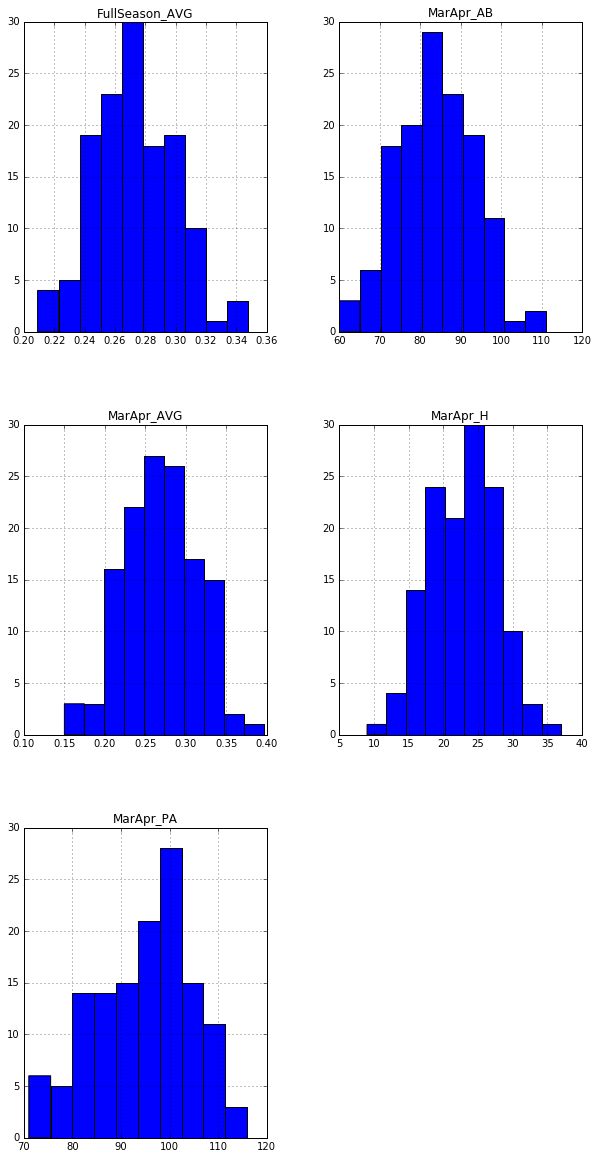

In [76]:
df.hist(figsize = (10, 20)) #We plot the histograms for each of the variables and see which kind of distributions they have

Since all the variables seem to have a normal distribution, is safe to use out-of-the-box regressors like Linear Regression to make an initial pass at the predictions. Since one of the assumptions in Linear Regression is the normality of the data.

## First pass with Linear Regression

I'll first use Linear Regression with an L2 Regularizer, also called Ridge Regression. Ridge Regressors are good when we have a relatively small number of features as well as few data points. Moreso whenever we consider all the features to be important.

In [77]:
#We use the built in Cross validation scheme in Scikit-Learn to build a robust classifier. 
# This allows us to search in the parameter space, while at the same time running cross validation
alpha_list = np.logspace(-3, 10, num=100)
model = RidgeCV(alphas = alpha_list, cv =3)

In [78]:
X = df.values[:,1:5] # We define our feature data and Labeled data
Y = df.FullSeason_AVG[:, None]

In [79]:
model.fit(X, Y)

RidgeCV(alphas=array([  1.00000e-03,   1.35305e-03, ...,   7.39072e+09,   1.00000e+10]),
    cv=3, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [80]:
print model.coef_
print model.alpha_

[[  9.94820930e-05   6.60402213e-05   1.88487962e-03   2.32049819e-05]]
1097.49876549


From the results, we can see that a relatively large alpha coefficint seemed to do a good work, which means the penalty to the weights is not that important to describe the data. 

Furthermore, in the coefficients, we can appreciate that the hits that the player did are far more predictive of his overall batting average than any other feature.

In [81]:
# We now run a prediction over the whole dataset and plot the results to see how did the regressor worked.
predict_x = model.predict(X)

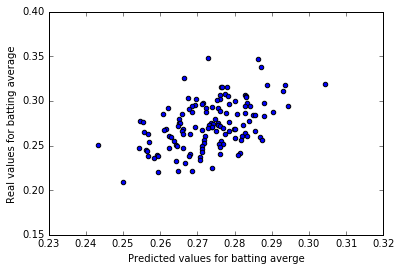

In [82]:
plt.scatter(predict_x, Y)
plt.xlabel('Predicted values for batting averge')
plt.ylabel('Real values for batting average')

In [83]:
# We now find quantitative metrics for our estimator
print metrics.mean_squared_error(Y, predict_x)
print metrics.median_absolute_error(Y, predict_x)
print metrics.r2_score(Y, predict_x)

0.000561426739082
0.0188503459394
0.223165855464


The $R^2$ score is not very good, but we are going to try with a different more powerful regression algorithm to see if we can improve the data.

## Random forest regressor.

After working with the most straightforward regression algorithm. We use Random Forest Regression, which is an ensemble model that generally does better than Ridge Regression. 

As an ensemble model, it also gets its strenght from the fact that it runs several classifiers (trees) at the same time. Alleviating the need to do extensive model testing.

Whether we need or not CV to evaluate the model is a contentious issue in the community. This issue stems form the fact that random forests already use only part of the data to do the training. I've personally found the Out of Bag Error (OoB) to be a good estimator of the error.

In [84]:
RANDOM_STATE = 2
Y_forst = Y[:, 0]
ensemble_forst = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features=None",
        RandomForestRegressor(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_forst)

min_estimators = 15
max_estimators = 200

for label, clf in ensemble_forst:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, Y_forst)

        oob_error = clf.oob_score_
        error_rate[label].append((i, oob_error))

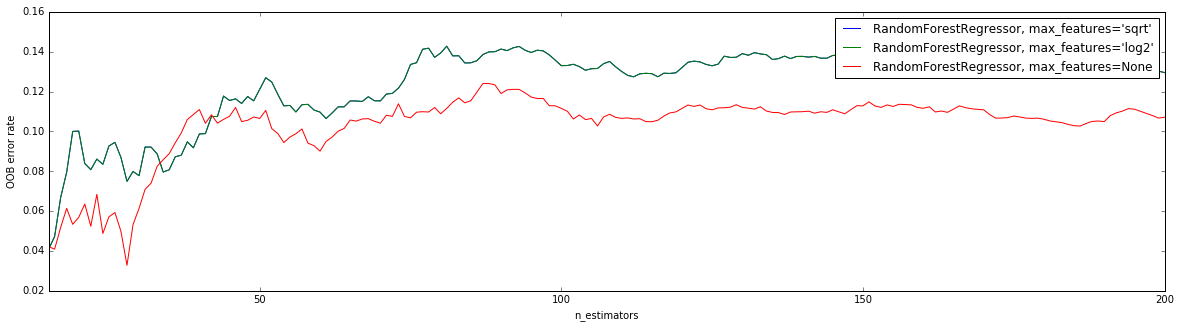

In [85]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
plt.figure(figsize=(20,5))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")

# Discussion

As we increase the number of estimators (trees), the random forest does better to a certain extent. It's OoB score goes up, and is as good as 14%, which is marginally worse than the Ridge Regressor. Which has an $R^2$ error of 22%.

One last approach I will do is transform the input data to account for covariance in the inpute data, as well as to account for difference in scaling of the input data. 

This can be achieved using PCA with whitening. This will transform the data and try and obtain features that do not covariate with one-another, while at the same time scaling them to the same magnitude. 

## PCA with whitening

In [86]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4, whiten = True)
pca.fit(X)
X_pca = pca.transform(X)
model.fit(X_pca, Y)
print model.coef_
print model.alpha_
predict_x = model.predict(X_pca)
print metrics.mean_squared_error(Y, predict_x)
print metrics.median_absolute_error(Y, predict_x)
print metrics.r2_score(Y, predict_x)

[[ 0.00512809  0.0059252   0.00365632 -0.00070756]]
72.2080901839
0.000565081524147
0.018240311357
0.21810880771


One downcome of PCA, is that it becomes very difficult to measure the significance of each real feature. PCA featues do not represent physical variables, but are in general good for finidng structure in the data.

We also see that the $R^2$ score is even worse, which means that the data itself probably doesn't have a structure that allows us to have a better regressor.

Now, I'll use the Random Forest, and see if we have better results using PCA features.

In [87]:
RANDOM_STATE = 2
Y_forst = Y[:, 0]
ensemble_forst = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features=None",
        RandomForestRegressor(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_forst)

min_estimators = 15
max_estimators = 200

for label, clf in ensemble_forst:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_pca, Y_forst)

        oob_error = clf.oob_score_
        error_rate[label].append((i, oob_error))

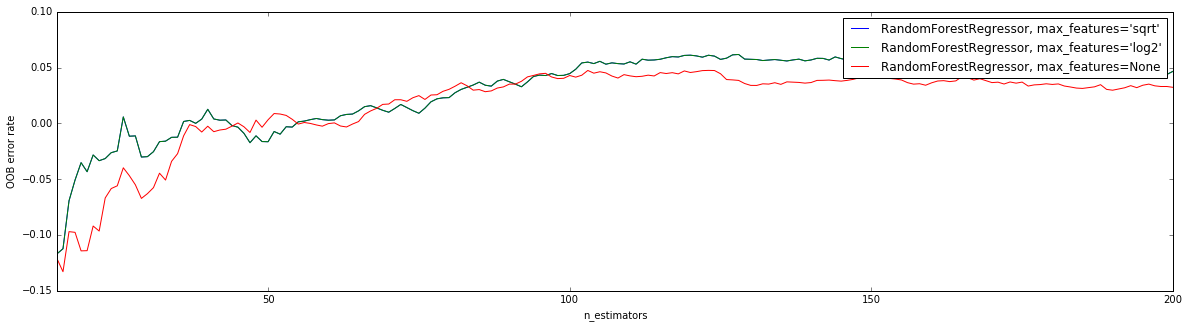

In [88]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
plt.figure(figsize=(20,5))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")

Again, PCA did nothing to enhance the result of the clasifiers.